Imports

In [23]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
import math
import librosa
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score,f1_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import RandomizedSearchCV

# Audio Load, Feature Extraction

In [72]:
relevant_genres = ['funk', 'hiphop', 'jazz', 'rock']

In [73]:
from scipy.io.wavfile import read as wavread
def ToolReadAudio(cAudioFilePath):    
    [samplerate, x] = wavread(cAudioFilePath)    
    if x.dtype == 'float32':        
        audio = x    
    else:        
        # change range to [-1,1)        
        if x.dtype == 'uint8':            
            nbits = 8        
        elif x.dtype == 'int16':            
            nbits = 16        
        elif x.dtype == 'int32':            
            nbits = 32        
        audio = x / float(2**(nbits - 1))    
        # special case of unsigned format    
    if x.dtype == 'uint8':        
        audio = audio - 1.    
    return (samplerate, audio)

Load ground truth file

In [74]:
import pandas as pd
info = pd.read_csv('./groove/info.csv')
#df=info[info['style'].isin(relevant_genres)]

#df.pivot(index='style', columns='beat_type', values='audio_filename')
df = pd.pivot_table(info, values='audio_filename', index=['style'],
                    columns=['beat_type'], aggfunc='count')
#df[df['beat'] >= 20]

info = info[info['style'].isin(relevant_genres)]
info = info[info['beat_type'] == "beat"]
info = info[info['audio_filename'].notna()].reset_index()
#locs = info['audio_filename'].to_numpy()


In [127]:
info.groupby('style')['audio'].count()

style
funk       28
hiphop     28
jazz       24
rock      167
Name: audio, dtype: int64

Load audio from the ground truth file and store in dataframe

In [75]:
info['audio'] = ''
for index, row in info.iterrows():
    #if index % 10 == 0:
        #print(index)
    try:
        sr,audio = ToolReadAudio('./groove/'+row['audio_filename'])
        if audio.shape[-1] == 2:
            info['audio'][index] = np.mean(audio,axis=1)
        else:
            info['audio'][index] = audio
        #info['audio'][index] = audio
    except Exception as e: # Some files are unable to be read by scipy's wavfile read, so skipping them and removing the corresponding rows
        info.drop(index,inplace=True)
        #print(e)
        
        print("Error, dropping row")
        print(f"size of info is now: {len(info)}")
info.reset_index(drop=True, inplace=True)
info.drop('index',axis=1,inplace=True)

<ipython-input-73-70eaf167f057>:3: WavFileWarning:

Chunk (non-data) not understood, skipping it.

<ipython-input-75-771846dd385f>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-75-771846dd385f>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Error, dropping row
size of info is now: 250
Error, dropping row
size of info is now: 249
Error, dropping row
size of info is now: 248
Error, dropping row
size of info is now: 247


Feature Extraction code

In [ ]:
def block_audio(x,blockSize,hopSize,fs):    
    # allocate memory    
    numBlocks = math.ceil(x.size / hopSize)    
    xb = np.zeros([numBlocks, blockSize])    
    # compute time stamps    
    t = (np.arange(0, numBlocks) * hopSize) / fs   
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)    
    for n in range(0, numBlocks):        
        i_start = n * hopSize        
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])        
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]    
    return (xb,t)
def agg_mfccs(x):
    mfccs = librosa.feature.mfcc(x,n_mfcc = 13)
    mean = [np.mean(feature) for feature in mfccs]
    std = [np.std(feature) for feature in mfccs]
    mfcc_delta = librosa.feature.delta(mfccs)
    delta_mean=[np.mean(feature) for feature in mfcc_delta]
    delta_std=[np.std(feature) for feature in mfcc_delta]
    return mean,std,delta_mean,delta_std

def extract_spectral_centroid(xb, fs):
    centroids = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,fs)
    #np.sum(magnitudes*freqs) / np.sum(magnitudes)
    for i in range(freqs.shape[0]):
        if np.all(stft[i] == 0):
            pass
        else:
            centroid = np.sum(stft[i]*freqs[i]) / np.sum(stft[i])
            centroids[i]=centroid
        #centroids.append(centroid)
    #centroids=np.array(centroids)
    return centroids

def extract_spectral_centroid(xb, fs):
    centroids = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,fs)
    #np.sum(magnitudes*freqs) / np.sum(magnitudes)
    for i in range(freqs.shape[0]):
        if np.all(stft[i] == 0):
            pass
        else:
            centroid = np.sum(stft[i]*freqs[i]) / np.sum(stft[i])
            centroids[i]=centroid
        #centroids.append(centroid)
    #centroids=np.array(centroids)
    return centroids
def calc_stft(xb,fs=44100):
    stft = np.zeros((xb.shape[0],(int(xb[0].shape[0]/2)+1)))
    freqs = np.zeros((xb.shape[0],(int(xb[0].shape[0]/2)+1)))
    window = np.hanning(xb[0].shape[0])
    for i in range(xb.shape[0]):
        block= xb[i]
        # Apply Window to the block
        windowed_block = window * block 
        stft_blk = np.fft.fft(windowed_block)
        #stft_blk = np.fft.rfft(windowed_block)
        freq=np.fft.fftfreq(block.size,1/fs)
        freqs[i]=freq[:int(block.size/2)+1]
        stft_blk = np.abs(stft_blk)
        #stft_block = stft_blk[int((stft_blk.shape[0])/2):]
        stft_block = stft_blk[:int(((stft_blk.shape[0])/2)+1)]
        #stft_db = 10*np.log10(stft_block) # IS THIS CORRECT??
        stft[i]=stft_block#stft_db
    stft = np.array(stft)
    freqs=np.array(freqs)
    return stft,freqs

def extract_spectral_centroid(xb, fs):
    centroids = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,fs)
    #np.sum(magnitudes*freqs) / np.sum(magnitudes)
    for i in range(freqs.shape[0]):
        if np.all(stft[i] == 0):
            pass
        else:
            centroid = np.sum(stft[i]*freqs[i]) / np.sum(stft[i])
            centroids[i]=centroid
        #centroids.append(centroid)
    #centroids=np.array(centroids)
    return centroids

def extract_rms(xb):
    rms = np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        if np.all(xb[i] == 0):
            r = 0.00001
        else:
            block = xb[i]
            r = np.sqrt(np.sum(block**2)/xb.shape[0])
            if r <= 0.00001: # Done to handle case when rms is 0 (for a block of all zeros
                r = 0.00001
            #rms.append(r)
        rms[i] = r
    #rms=np.array(rms)
    return 20*np.log10(rms)#rms,20*np.log10(rms) # What is reference value to convert to dB? Is it 1?

def extract_zerocrossingrate(xb):
    zcr= np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        if np.all(xb[i] == 0):
            pass
        else:
            block = xb[i]
            zero_crossings = np.sum(np.abs(np.diff(np.sign(block)))) / block.shape[0] #np.nonzero(np.diff(block > 0))[0].size
            #zcr.append(zero_crossings)
            zcr[i] = zero_crossings 
    #zcr = np.array(zcr)
    return zcr

def extract_spectral_crest(xb):
    crest = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,44100)
    for i in range(stft.shape[0]):
        if np.all(stft[i] == 0):
            pass
        else:
            #crest.append((np.max(stft[i])/np.sum(stft[i])))
            crest[i] = np.max(stft[i])/np.sum(stft[i])
    #crest = np.array(crest)
    return crest

def extract_spectral_flux(xb):
    num_blocks=xb.shape[0] 
    blockSize = xb.shape[1]
    spectral_flux = np.zeros(num_blocks)
    stft,freqs = calc_stft(xb,44100)
    fft_len= stft.shape[1]
    n = 0
    k = 0
    for n in range(1,num_blocks):
        if np.all(stft[n] == 0):
            pass
        else:
            sum_flux = 0
            for k in range(fft_len):
                f = (abs(stft[n, k]) - abs(stft[n-1, k]))**2
                sum_flux += f
            flux = np.sqrt(sum_flux)/((blockSize/2)+1)
            spectral_flux[n] = flux #first flux value will be 0
    return spectral_flux
def get_novelty(xb):
    N = 2048#xb.shape[1]
    w = scipy.signal.hann(N)
    novelty=np.zeros([xb.shape[0],xb.shape[1]])
    for i in range(xb.shape[0]):
        xb_square = xb[i]**2
        energy_local = np.convolve(xb_square, w**2, 'same')
        energy_local_diff = np.diff(energy_local)
        energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
        novelty_energy = np.copy(energy_local_diff)
        novelty_energy[energy_local_diff < 0] = 0
        novelty[i] = novelty_energy
    return novelty
def get_num_onsets(novelty,thresh):
    onsets=np.zeros(novelty.shape[0])
    for i in range(novelty.shape[0]):
        p = scipy.signal.find_peaks(novelty[i])[0]
        onsets[i]=(novelty[i][p] >= thresh).sum()
    return onsets
def get_onset_data(xb,threshold):
    novelty=get_novelty(xb)
    onsets = get_num_onsets(novelty,threshold)
    return onsets#, (onsets/durationInSecs)

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_onsets_in_freq_bands(x,blockSize,hopSize,fs,threshold=0.001,fl1=20,fh1=400,fl2=400,fh2=3000,fl3=8000,fh3=15000):
    x1 = butter_bandpass_filter(x,fl1,fh1,fs)
    x2 = butter_bandpass_filter(x,fl2,fh2,fs)
    x3 = butter_bandpass_filter(x,fl3,fh3,fs)

    xb1,_ = block_audio(x1,blockSize,hopSize,fs)
    xb2,_ = block_audio(x2,blockSize,hopSize,fs)
    xb3,_ = block_audio(x3,blockSize,hopSize,fs)

    onsets1 = get_onset_data(xb1,0.0000001)
    onsets2 = get_onset_data(xb2,0.0001)
    onsets3 = get_onset_data(xb3,0.00001)
    return onsets1, onsets2, onsets3

def extract_manual_features(x,fs):

    xb,ts = block_audio(x,2048,1024,fs)
    centroid = extract_spectral_centroid(xb,fs)
    rms = extract_rms(xb)
    zcr = extract_zerocrossingrate(xb)
    crest = extract_spectral_crest(xb)
    flux = extract_spectral_flux(xb)

    centroid_mean = np.mean(centroid)
    centroid_std = np.std(centroid)

    rms_mean = np.mean(rms)
    rms_std = np.std(rms)

    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    crest_mean = np.mean(crest)
    crest_std = np.std(crest)

    flux_mean = np.mean(flux)
    flux_std = np.std(flux)

    xb2,ts2 = block_audio(x,int(fs*1),int(fs*0.5),fs)
    onsets = get_onset_data(xb2,0.001)

    onsets_mean = np.mean(onsets)
    onsets_std = np.std(onsets)

    onsets1,onsets2,onsets3 = get_onsets_in_freq_bands(x,2048,1024,fs)
    # onsets1_mean = np.mean(onsets1)
    onsets2_mean = np.mean(onsets2)
    onsets3_mean = np.mean(onsets3)
    
    # onsets1_std = np.std(onsets1)
    onsets2_std = np.std(onsets2)
    onsets3_std = np.std(onsets3)

    return centroid_mean, centroid_std, rms_mean, rms_std, zcr_mean, zcr_std, crest_mean, crest_std, \
        flux_mean,flux_std,onsets_mean,onsets_std,onsets2_mean,onsets3_mean,onsets2_std,onsets3_std

Extract features and store in dataframe

In [ ]:
df=info
df['mfcc_mean'] = ''
df['mfcc_std'] = ''

df['delta_mfcc_mean'] = ''
df['delta_mfcc_std'] = ''

df['centroid_mean'] = ''
df['centroid_std'] = ''

df['rms_mean'] = ''
df['rms_std'] = ''

df['zcr_mean'] = ''
df['zcr_std'] = ''

df['crest_mean'] = ''
df['crest_std'] = ''

df['flux_mean'] = ''
df['flux_std'] = ''

df['onsets_mean'] = ''
df['onsets_std'] = ''

df['onsets_mid_mean'] = ''
df['onsets_mid_std'] = ''

df['onsets_high_mean'] = ''
df['onsets_high_std'] = ''
for i in range(len(df)):
    #print(df['audio'][i].shape)
    mean,std,delta_mean,delta_std = agg_mfccs(df['audio'][i])
    # Extract 13 MFCCs - get mean and std deviation for each (26 features) + Delta MFCCs (26 features) = total 52 Features
    df['mfcc_mean'][i] = mean
    df['mfcc_std'][i] = std
    df['delta_mfcc_mean'][i] = delta_mean
    df['delta_mfcc_std'][i] = delta_std

    centroid_mean, centroid_std, rms_mean, rms_std, zcr_mean, zcr_std, crest_mean, crest_std, flux_mean,flux_std,onsets_mean,onsets_std,onsets2_mean,onsets3_mean,onsets2_std,onsets3_std \
         = extract_manual_features(df['audio'][i],44100)
    df['centroid_mean'][i] = centroid_mean
    df['centroid_std'][i] = centroid_std
    df['rms_mean'][i] = rms_mean
    df['rms_std'][i] = rms_std
    df['zcr_mean'][i] = zcr_mean
    df['zcr_std'][i] = zcr_std
    df['crest_mean'][i] = crest_mean
    df['crest_std'][i] = crest_std
    df['flux_mean'][i] = flux_mean
    df['flux_std'][i] = flux_std
    df['onsets_mean'][i] = onsets_mean
    df['onsets_std'][i] = onsets_std

    # df['onsets_low_mean'][i] = onsets1_mean
    # df['onsets_low_std'][i] = onsets1_std

    df['onsets_mid_mean'][i] = onsets2_mean
    df['onsets_mid_std'][i] = onsets2_std

    df['onsets_high_mean'][i] = onsets3_mean
    df['onsets_high_std'][i] = onsets3_std


df[['mfcc1_mean','mfcc2_mean','mfcc3_mean','mfcc4_mean','mfcc5_mean','mfcc6_mean','mfcc7_mean','mfcc8_mean','mfcc9_mean','mfcc10_mean','mfcc11_mean','mfcc12_mean','mfcc13_mean']]=pd.DataFrame(df.mfcc_mean.tolist(), index= df.index)
df[['mfcc1_std','mfcc2_std','mfcc3_std','mfcc4_std','mfcc5_std','mfcc6_std','mfcc7_std','mfcc8_std','mfcc9_std','mfcc10_std','mfcc11_std','mfcc12_std','mfcc13_std']]=pd.DataFrame(df.mfcc_std.tolist(), index= df.index)

df[['delta_mfcc1_mean','delta_mfcc2_mean','delta_mfcc3_mean','delta_mfcc4_mean','delta_mfcc5_mean','delta_mfcc6_mean','delta_mfcc7_mean','delta_mfcc8_mean','delta_mfcc9_mean','delta_mfcc10_mean','delta_mfcc11_mean','delta_mfcc12_mean','delta_mfcc13_mean']]=pd.DataFrame(df.delta_mfcc_mean.tolist(), index= df.index)
df[['delta_mfcc1_std','delta_mfcc2_std','delta_mfcc3_std','delta_mfcc4_std','delta_mfcc5_std','delta_mfcc6_std','delta_mfcc7_std','delta_mfcc8_std','delta_mfcc9_std','delta_mfcc10_std','delta_mfcc11_std','delta_mfcc12_std','delta_mfcc13_std']]=pd.DataFrame(df.delta_mfcc_std.tolist(), index= df.index)


In [ ]:
out = df.to_numpy()
np.save('./resources/working_data/data.npy', out)

# Load Feature File and classify

In [134]:
names=['drummer', 'session', 'id', 'style', 'bpm', 'beat_type',
       'time_signature', 'midi_filename', 'audio_filename', 'duration',
       'split', 'audio', 'mfcc_mean', 'mfcc_std', 'delta_mfcc_mean',
       'delta_mfcc_std', 'centroid_mean', 'centroid_std', 'rms_mean',
       'rms_std', 'zcr_mean', 'zcr_std', 'crest_mean', 'crest_std',
       'flux_mean', 'flux_std', 'onsets_mean', 'onsets_std', 'mfcc1_mean',
       'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean',
       'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean',
       'mfcc12_mean', 'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std',
       'mfcc4_std', 'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std',
       'mfcc9_std', 'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std', 'onsets_low_mean',
       'onsets_low_std','onsets_mid_mean', 'onsets_mid_std',
       'onsets_high_mean', 'onsets_high_std']
df=pd.DataFrame(np.load('./resources/working_data/data.npy',allow_pickle=True),columns=names)

Correlation plot of features

<class 'pandas.core.frame.DataFrame'>
(247, 68)
(68, 68)


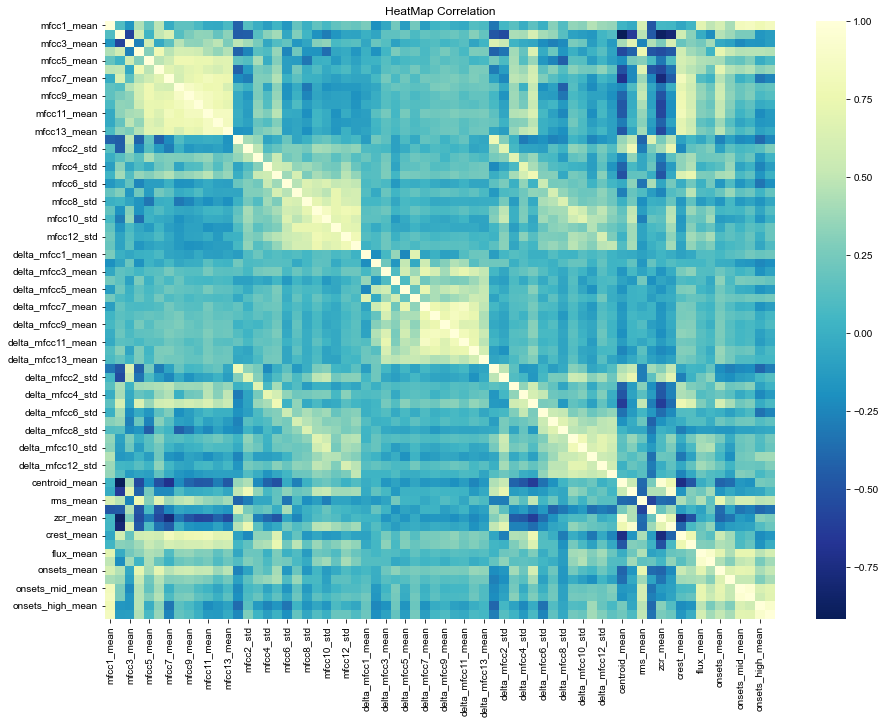

In [146]:
# All features Correlation map
df_cols = df[['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',\
       'centroid_mean','centroid_std','rms_mean','rms_std','zcr_mean',
       'zcr_std','crest_mean','crest_std','flux_mean','flux_std',
       'onsets_mean', 'onsets_std','onsets_mid_mean', 'onsets_mid_std',
       'onsets_high_mean', 'onsets_high_std']]
print(type(df_cols))
print(df_cols.shape)
corrMatrix = df_cols.astype('float64').corr(method = "pearson")
print(corrMatrix.shape)
'''
HEATMAP
'''
import seaborn as sn
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,11))
sn.heatmap(corrMatrix, annot=False, cmap='YlGnBu_r')
sn.set(font_scale = 1, style = 'white')
plt.title('HeatMap Correlation')
plt.show()

Scatter plot of features

In [144]:
import plotly.express as px
lst=df.columns
lst=['style','mfcc1_std', 'flux_mean', 'delta_mfcc1_std', 'flux_std', 'mfcc2_mean',
       'mfcc9_mean', 'delta_mfcc10_std', 'zcr_std', 'mfcc13_mean',
       'mfcc8_mean', 'delta_mfcc2_std', 'mfcc11_mean', 'centroid_std',
       'mfcc10_mean', 'rms_std', 'centroid_mean', 'onsets_mid_std',
       'delta_mfcc13_mean', 'mfcc13_std', 'mfcc2_std', 'delta_mfcc2_mean',
       'delta_mfcc3_std', 'delta_mfcc8_std', 'rms_mean', 'delta_mfcc9_std']
fig = px.scatter_matrix(df[lst],dimensions=['delta_mfcc13_mean', 'mfcc13_std', 'mfcc2_std', 'delta_mfcc2_mean',
       'delta_mfcc3_std', 'delta_mfcc8_std', 'rms_mean', 'delta_mfcc9_std'],color='style')
fig.update_layout(
    autosize=True,
    width=1500,
    height=1500
)
fig.show()

In [26]:
X_allfeatures = df[['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',\
       'centroid_mean','centroid_std','rms_mean','rms_std','zcr_mean',
       'zcr_std','crest_mean','crest_std','flux_mean','flux_std',
       'onsets_mean', 'onsets_std','onsets_mid_mean', 'onsets_mid_std',
       'onsets_high_mean', 'onsets_high_std']]

y=df[['style']]

In [27]:
#FEATURE SELECTION
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.5) # Variance threshold 
sel = selector.fit(X_allfeatures)
sel_index = sel.get_support()
X_vt = X_allfeatures.iloc[:, sel_index]
print(X_vt.columns)
print(len(X_vt.columns))

Index(['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean',
       'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean',
       'mfcc11_mean', 'mfcc12_mean', 'mfcc13_mean', 'mfcc1_std', 'mfcc2_std',
       'mfcc3_std', 'mfcc4_std', 'mfcc5_std', 'mfcc6_std', 'mfcc7_std',
       'mfcc8_std', 'mfcc9_std', 'mfcc10_std', 'mfcc11_std', 'mfcc12_std',
       'mfcc13_std', 'delta_mfcc1_std', 'delta_mfcc2_std', 'centroid_mean',
       'centroid_std', 'rms_mean', 'rms_std', 'onsets_mean', 'onsets_std'],
      dtype='object')
34


In [28]:
from sklearn.feature_selection import mutual_info_classif
threshold = 25  # the number of most relevant features
high_score_features = []
feature_scores = mutual_info_classif(X_allfeatures, y, random_state=0)
for score, f_name in sorted(zip(feature_scores, X_allfeatures.columns), reverse=True)[:threshold]:
        print(f_name, score)
        high_score_features.append(f_name)
X_mic = X_allfeatures[high_score_features]
print(X_mic.columns)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



mfcc1_std 0.19571416472480374
flux_mean 0.18946082626843608
delta_mfcc1_std 0.17146268280202936
flux_std 0.1691835113249054
mfcc2_mean 0.16391999508760668
mfcc9_mean 0.1564266169681845
delta_mfcc10_std 0.15125969257156835
zcr_std 0.1498671756544192
mfcc13_mean 0.14709893638139127
mfcc8_mean 0.14374131132867474
delta_mfcc2_std 0.14059785386746948
mfcc11_mean 0.13268130431894432
centroid_std 0.1267104351178172
mfcc10_mean 0.12365698771666
rms_std 0.12150884656847638
centroid_mean 0.1196435291237734
onsets_mid_std 0.1165737382301828
delta_mfcc13_mean 0.11574028517528401
mfcc13_std 0.11167288387253627
mfcc2_std 0.11028943724045215
delta_mfcc2_mean 0.10480984695020523
delta_mfcc3_std 0.10225179505608484
delta_mfcc8_std 0.09714559465137595
rms_mean 0.09557731555876336
delta_mfcc9_std 0.09517276092111637
Index(['mfcc1_std', 'flux_mean', 'delta_mfcc1_std', 'flux_std', 'mfcc2_mean',
       'mfcc9_mean', 'delta_mfcc10_std', 'zcr_std', 'mfcc13_mean',
       'mfcc8_mean', 'delta_mfcc2_std', 'mfcc1

In [70]:
features=['mfcc1_std', 'flux_mean', 'delta_mfcc1_std', 'flux_std', 'mfcc2_mean',
       'mfcc9_mean', 'delta_mfcc10_std', 'zcr_std', 'mfcc13_mean',
       'mfcc8_mean', 'delta_mfcc2_std', 'mfcc11_mean', 'centroid_std',
       'mfcc10_mean', 'rms_std', 'centroid_mean', 'onsets_mid_std',
       'delta_mfcc13_mean', 'mfcc13_std', 'mfcc2_std', 'delta_mfcc2_mean',
       'delta_mfcc3_std', 'delta_mfcc8_std', 'rms_mean', 'delta_mfcc9_std']
X = df[features]
y=df[['style']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=29)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Hyperparameter Optimisation

In [ ]:
for col in X.columns:
    #df[col] = df[col]/max(np.abs(df[col]))
    mean = np.mean(X[col])
    std = np.std(X[col])
    X[col] = (X[col] - mean)/std # z-score normalization
X_train, X_test, y_train, y_test = train_test_split(X_mic, y, test_size=0.33)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
warnings.filterwarnings("ignore")
C = [x**0.01 for x in range(25,200)]
kernel = ['rbf','linear','poly','sigmoid']
degree = [int(x) for x in range(1,8)]
gamma = ['scale','auto']
coef0 = [x*0.1 for x in range(0,40)]
decision_function_shape = ['ovo','ovr']
svm_grid = { 'C' : C,
            'kernel' : kernel,
            'degree' : degree,
            'gamma' : gamma,
            'coef0' : coef0,
            'decision_function_shape' : decision_function_shape
            }
svc = SVC()
svm_df=pd.DataFrame()
svm_df['trial']=[]
svm_df['training_acc']=[]
svm_df['accuracy'] = []
svm_df['macro_accuracy'] = []
svm_df['confusion_matrix']=[]
svm_df['params']=[]
svm_df['cv_acc']=[]
svm_df['cv_std']=[]
trial=[]
training_acc = []
accuracy=[]
macro_accuracy=[]
confusion=[]
params=[]
cv_acc=[]
cv_std=[]
for i in range(0,50):
    trial.append(i)
    #Optimize Hyperparameters
    svc_RandomGrid = RandomizedSearchCV(estimator = svc, param_distributions=svm_grid,cv=10,verbose=0,n_jobs=4) #verbose=2
    svc_RandomGrid.fit(X_train,y_train)
    #print(f'Training CV Accuracy: {svc_RandomGrid.best_score_}')
    training_acc.append(svc_RandomGrid.best_score_)
    #print(svc_RandomGrid.best_params_)
    params.append(svc_RandomGrid.best_params_)
    #Predict based on hyperparameters that are optimized
    y_prediction = svc_RandomGrid.predict(X_test)
    #Calculate accuracy scores for testing
    score=balanced_accuracy_score(y_test, y_prediction)
    acc = accuracy_score(y_test, y_prediction)
    cm = confusion_matrix(y_test, y_prediction) # clean, highfry, layered, lowfry, midfry, no vocals

    accuracy.append(acc)
    macro_accuracy.append(score)
    confusion.append(cm)
    # scores = cross_validate(svc_RandomGrid, X_train, y_train, cv=10)
    # cv_acc.append(scores['test_score'].mean())
    # cv_std.append(scores['test_score'].std())
    # print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))
    #print(f"Confusion Matrix:\n {cm}")
    #print(f"Accuracy score: {accuracy}")
    #print(f"Macro accuracy score: {score}")


svm_df['trial']= trial
svm_df['cv_acc']=training_acc
svm_df['accuracy'] = accuracy
svm_df['macro_accuracy'] = macro_accuracy
svm_df['confusion_matrix']=confusion
svm_df['params']=params
# svm_df['cv_acc']=cv_acc
# svm_df['cv_std']=cv_std

svm_df['macro_accuracy'].max()

## Classification

In [79]:
print("-------------------------------------------------------------------------------")
print("            KNN             ")
print("-------------------------------------------------------------------------------")
KNN_model = KNeighborsClassifier(n_neighbors=7)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)
score=balanced_accuracy_score(y_test, KNN_prediction)
accuracy = accuracy_score(y_test, KNN_prediction)
f1=f1_score(y_test,KNN_prediction,average='macro')
cm_knn = confusion_matrix(y_test, KNN_prediction) 
print(f"Confusion Matrix:\n {cm_knn}")
print(cm_knn/cm_knn.sum(axis=1))
print(f"Accuracy score: {accuracy}")
print(f"Macro accuracy score: {score}")
print(f"F1 score: {f1}")

print("-------------------------------------------------------------------------------")
print("            SVM             ")
print("-------------------------------------------------------------------------------")
SVM_model = make_pipeline(StandardScaler(), SVC(kernel='poly',gamma='scale',degree=3,decision_function_shape='ovr',coef0=0.7000000000000001,C=1.053475672085955,random_state=0))
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=balanced_accuracy_score(y_test, SVM_prediction)
cm_svm = confusion_matrix(y_test, SVM_prediction) 
f1=f1_score(y_test,SVM_prediction,average='macro')
acc = accuracy_score(y_test, SVM_prediction)
print(cm_svm)
print(cm_svm/cm_svm.sum(axis=1))
print("Accuracy Score: ",acc)
print("Macro accuracy Score:",score)
print(f"F1 score: {f1}")

print("-------------------------------------------------------------------------------")
print("            RF              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=800,min_samples_split = 8, min_samples_leaf = 2,max_leaf_nodes = 29, max_depth = 796, criterion = 'entropy',class_weight='balanced',random_state=0)
RF_model.fit(X_train, y_train)
# scores = cross_validate(RF_model, X_train, y_train, cv=10)
RF_prediction = RF_model.predict(X_test)
score=balanced_accuracy_score(y_test, RF_prediction)
cm_rf = confusion_matrix(y_test, RF_prediction) 
f1=f1_score(y_test,RF_prediction,average='macro')
acc = accuracy_score(y_test, RF_prediction)
print(cm_rf)
print(cm_rf/cm_rf.sum(axis=1))
print("Accuracy Score: ",acc)
print("Macro accuracy Score:",score)
print(f"F1 score: {f1}")

-------------------------------------------------------------------------------
            KNN             
-------------------------------------------------------------------------------
Confusion Matrix:
 [[ 6  1  0  2]
 [ 0  4  0  4]
 [ 0  1  1  6]
 [ 2  0  1 47]]
[[0.66666667 0.125      0.         0.04      ]
 [0.         0.5        0.         0.08      ]
 [0.         0.125      0.125      0.12      ]
 [0.22222222 0.         0.125      0.94      ]]
Accuracy score: 0.7733333333333333
Macro accuracy score: 0.5579166666666666
F1 score: 0.5849240613676663
-------------------------------------------------------------------------------
            SVM             
-------------------------------------------------------------------------------
[[ 6  0  0  3]
 [ 0  0  0  8]
 [ 0  0  6  2]
 [ 0  0  2 48]]
[[0.66666667 0.         0.         0.06      ]
 [0.         0.         0.         0.16      ]
 [0.         0.         0.75       0.04      ]
 [0.         0.         0.25       0.96      ]

/usr/local/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

<ipython-input-79-4e567a6bbaa9>:38: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[[ 6  0  0  3]
 [ 0  3  0  5]
 [ 0  0  5  3]
 [ 0  1  2 47]]
[[0.66666667 0.         0.         0.06      ]
 [0.         0.375      0.         0.1       ]
 [0.         0.         0.625      0.06      ]
 [0.         0.125      0.25       0.94      ]]
Accuracy Score:  0.8133333333333334
Macro accuracy Score: 0.6516666666666666
F1 score: 0.7092592592592593


In [147]:
scores = cross_validate(RF_model, X_train, y_train, cv=10)
# print(scores['test_score'].mean())
# print(scores['test_score'].std())
print("Accuracy: %0.2f (+/- %0.4f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))
# print(scores)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.9/site-packages/s

Accuracy: 0.70 (+/- 0.1573)


{'fit_time': array([1.11058998, 1.21796393, 1.12736702, 1.11448216, 1.05590916,
        1.40191913, 1.18972683, 1.21288204, 1.11625123, 1.12712789]),
 'score_time': array([0.08088493, 0.08326197, 0.06420708, 0.08509707, 0.06427503,
        0.10059977, 0.07270813, 0.06846189, 0.06622791, 0.08391595]),
 'test_score': array([0.66666667, 0.61111111, 0.58823529, 0.64705882, 0.82352941,
        0.76470588, 0.82352941, 0.70588235, 0.70588235, 0.64705882])}

# Plots

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay

In [83]:
RF_model.classes_

array(['funk', 'hiphop', 'jazz', 'rock'], dtype=object)

In [99]:
cm_rf/cm_rf.sum(axis=1)

array([[0.66666667, 0.        , 0.        , 0.06      ],
       [0.        , 0.375     , 0.        , 0.1       ],
       [0.        , 0.        , 0.625     , 0.06      ],
       [0.        , 0.125     , 0.25      , 0.94      ]])

In [100]:
cm_svm/cm_svm.sum(axis=1)

array([[0.66666667, 0.        , 0.        , 0.06      ],
       [0.        , 0.        , 0.        , 0.16      ],
       [0.        , 0.        , 0.75      , 0.04      ],
       [0.        , 0.        , 0.25      , 0.96      ]])

In [101]:
cm_knn/cm_knn.sum(axis=1)

array([[0.66666667, 0.125     , 0.        , 0.04      ],
       [0.        , 0.5       , 0.        , 0.08      ],
       [0.        , 0.125     , 0.125     , 0.12      ],
       [0.22222222, 0.        , 0.125     , 0.94      ]])

In [105]:
import numpy as np
import pandas as pd
classes=KNN_model.classes_
knn_classwise=np.array([0.6666,0.5,0.125,0.94])
rf_classwise = np.array([0.6666,0.375,0.625,0.94])
svm_classwise = np.array([0.6666,0,0.75,0.96])
# fcnn_classwise = np.array([.6271,.5357,.1935,.0298,.3333,.8108])
# cnn_classwise = np.array([0.8953,0.8127,0.9180])

df=pd.DataFrame()

df['kNN']=knn_classwise
df['Random Forest'] = rf_classwise
df['SVM'] = svm_classwise
# df['Fully Connected Network'] = fcnn_classwise
# df['CNN'] = cnn_classwise

df=df.T
df.columns=classes
df=df.T

import plotly.express as px
fig=px.bar(df,x=df.index,y=['kNN','Random Forest','SVM'],barmode='group')
fig.update_layout(
    autosize=True,
    width=1200,
    height=800,
    title={
        'text': "Classwise accuracies",
        'x':0.5,
        'y':0.95,
        'xanchor': 'center',
        'yanchor': 'top',
        },
    font=dict(
        size=28
    ),
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=0
    ),
    legend=dict(
    orientation="h",
    yanchor="top",
    y=-0.2,
    xanchor="center",
    x=0.5

)
    )
fig.update_xaxes(
        tickangle = -19,
        title_text = "",
        title_font = {"size": 1},
        title_standoff = 0)
fig.update_yaxes(
        tickangle = 0,
        title_text = "Accuracy",
        title_font = {"size": 36},
        title_standoff = 50)
fig.update_layout(legend_title_text='')
fig.update_layout(yaxis= { 'tickformat': ',.0%'})
fig.update_xaxes(automargin=True)
fig.write_image("/Users/vedant/Desktop/Programming/ACA-project/classwise-accuracies.jpg", format="jpg", width=1200, height=800, scale=2)
fig

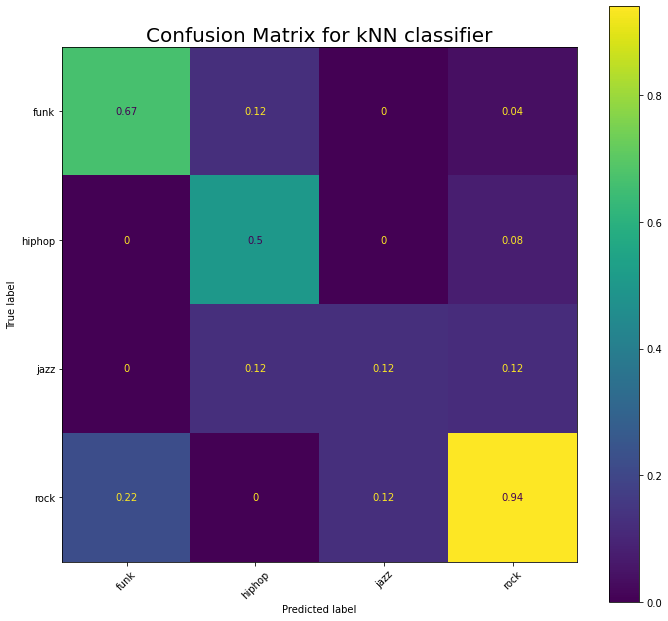

In [106]:
l=KNN_model.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn/cm_knn.sum(axis=1),display_labels=l)
disp.plot(xticks_rotation=45)
fig = plt.gcf()
fig.set_size_inches(10, 9)
plt.tight_layout()
plt.title("Confusion Matrix for kNN classifier",fontsize=20)
plt.savefig('/Users/vedant/Desktop/Programming/ACA-project/knn_cm.jpg')

In [109]:
cm_svm.sum(axis=1)

array([ 9,  8,  8, 50])

In [116]:
cm_svm[0]

array([6, 0, 0, 3])

In [117]:
cm_svm[0].sum()

9

In [124]:
c = np.zeros([4,4])
for i in range(cm_knn.shape[0]):
    c[i] = cm_knn[i]/cm_knn[i].sum()

c

array([[0.66666667, 0.11111111, 0.        , 0.22222222],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.125     , 0.125     , 0.75      ],
       [0.04      , 0.        , 0.02      , 0.94      ]])

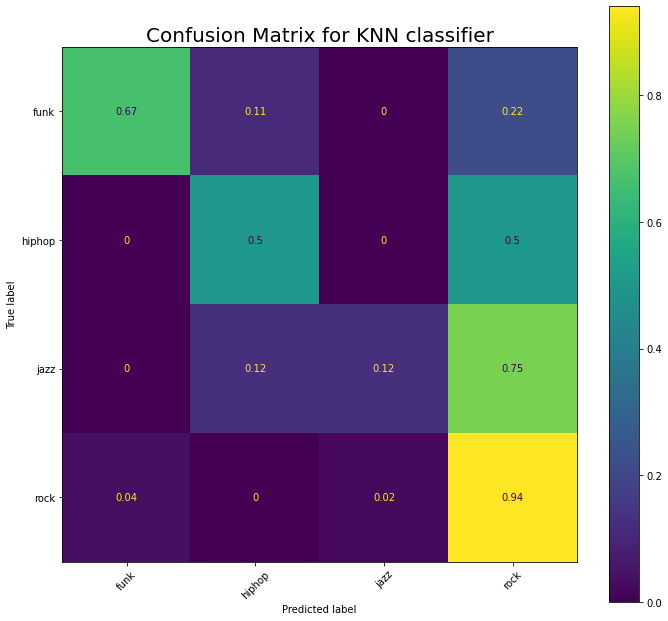

In [125]:
l=SVM_model.classes_
disp = ConfusionMatrixDisplay(c,display_labels=l)
disp.plot(xticks_rotation=45)
fig = plt.gcf()
fig.set_size_inches(10, 9)
plt.tight_layout()
plt.title("Confusion Matrix for KNN classifier",fontsize=20)
plt.savefig('/Users/vedant/Desktop/Programming/ACA-project/knn_cm.jpg')